# Security Market Line

## Team Members


| Name | EID |
| --- | --- |
| Akshat Johari | aj32864 |
| Aritra Chowdhury  | ac79277 |
| Brandt Green | bwg537 |

### Assumptions/Notes:
* Market Return is taken to be the total return on the SP500
* Risk Free Rate is the interest rate based on 30-day T-Bills
* Data frequency is Monthly
  
### Data Sources (All from WRDS)
 * [Stock Data](https://wrds-www.wharton.upenn.edu/pages/get-data/compustat-capital-iq-standard-poors/compustat/north-america-daily/security-monthly/)
 * [S&P 500 Data](https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/annual-update/index-sp-500-indexes/portfolios-on-sp-500/)
 * [Risk-Free Rates](https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/annual-update/treasuries/riskfree-series-1-month-and-3-month/)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import statsmodels.api as sm
from statsmodels.formula.api import ols
import datetime
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.5f' % x)

Uncomment out below cell on the first run of this notebook so that you can connect to WRDS database. Afterwards, comment it out so that when you run all cells, you are not prompted to reconnect.

In [6]:
# Establish connection to WRDS
# import wrds
# db = wrds.Connection()

### Input User Parameters
Two Options:
1. Enter your chosen parameters in the cell directly below.
2. Uncomment out the second cell below and run it which will prompt you for the same inputs.

In [7]:
start_date = '2015-12-31'
end_date = '2020-12-31'
ticker = 'AAPL'

In [8]:
# # Input Start Date
# while(True):
#     start_date = input('Please enter Start Date in YYYY-MM-DD form: ')
#     try:
#         datetime.datetime.strptime(start_date, '%Y-%M-%d')

#     except ValueError:
#         print('Invalid date format.')


# # Input End Date
#     end_date = input('Please enter End Date in YYYY-MM-DD form: ')
#     try:
#         datetime.datetime.strptime(end_date, '%Y-%M-%d')
#         if(end_date < start_date):
#             print('End date should be later than the Start date.')
#             break
#     except ValueError:
#         print('Invalid date format.')
#         break

# # Input Ticker
#     query_string = f"""SELECT DISTINCT tic FROM comp.secm where datadate >= '{start_date}' and datadate <= '{end_date}'"""
#     ticker_list = db.raw_sql(query_string)['tic'].to_list()
#     ticker = input('Please enter Ticker: ')
#     if ticker in ticker_list:
#         print(f'Start Date: {start_date}\nEnd Dat: {end_date}\nTicker: {ticker}')
#         break
#     else:
#         print('Invalid Ticker.')

#### Chosen Inputs:

In [9]:
print(f'Start Date: {start_date}\nEnd Date: {end_date}\nTicker: {ticker}')

Start Date: 2015-12-31
End Date: 2020-12-31
Ticker: AAPL


## Data Extraction
### Monthly Stock Data
Below, we query the appropriate stock data from WRDS based on the inputted ticker and redefine the column names for easier interpretability. 

In [10]:
query_string = f"""SELECT * FROM comp.secm where tic = '{ticker}' and datadate >= '{start_date}' and datadate <= '{end_date}' order by datadate"""
stock_data = db.raw_sql(query_string)
stock_data = stock_data[['datadate','tic','conm','prccm','trfm','trt1m']]
stock_data.columns = ['date','ticker','name','price','stock_return_factor', 'stock_return']
stock_data['stock_return'] = stock_data['stock_return'] / 100 # Returns are given in percents initially
stock_data = stock_data[1:]
# stock_data.head()

### Monthly Market Data
We use the S&P 500 Returns as the proxy for Market Returns.  

In [11]:
query_string = f"""SELECT * FROM crsp.msp500 where caldt >= '{start_date}' """
market_data = db.raw_sql(query_string)
market_data = market_data[['caldt','vwretd']] # vwretd is the total return on the index per period. This is given as a decimal value already
market_data.columns = ['date','market_return']
market_data = market_data[1:]
# market_data.head()

### Monthly Risk Free Data
To calculate the risk free rate of return for each period, we take the annualized, 1-month T-Bill Rate from WRDS and deannualize the rate to fine the one month T-Bill rate available at that point in time. Then, we shift that return one period forward to account for the fact that this month's market rate will be next month's return, which is what we need to use for comparison with the stock and market returns.

In [12]:
query_string = f"""SELECT * FROM crsp.tfz_mth_rf where tmduratn < 40 and mcaldt >= '{start_date}'"""
rf_data = db.raw_sql(query_string)
# Below we convert from annual rate to monthly and from % to decimal return. 
# Also shifting data so that this periods risk free rate in the market is next periods return
rf_data['rf_return'] = (rf_data['tmytm'] * rf_data['tmduratn'] / 36500).shift(1)
rf_data = rf_data[['mcaldt','rf_return']]
rf_data.columns = ['date','rf_return']
rf_data = rf_data[1:]
# rf_data.head()

We have our data sets, so now we just need to merge them and clean them up a bit to make sure they are all consistent.

In [13]:
# Merge Tables

all_data = stock_data.merge(market_data, left_index=True,right_index=True) # Merge stock returns and market returs
all_data = all_data.merge(rf_data, left_index=True,right_index=True) # Merge risk free returns onto above

In [14]:
# Clean up the data
cleaned_data = all_data.copy()

# Add risk premium columns
cleaned_data['market_risk_premium'] = cleaned_data['market_return'] - cleaned_data['rf_return']
cleaned_data['stock_risk_premium'] = cleaned_data['stock_return'] - cleaned_data['rf_return']
cleaned_data = cleaned_data.drop(columns=['date_x','date_y'])
# cleaned_data.head()

## Regression
Now that we have the desired data, we can conduct our analysis and plot the SML. We run a regression of the following form:

$$ StockRiskPremium = \alpha + \beta*MarketRiskPremium + \epsilon $$

### Security Characteristic Line

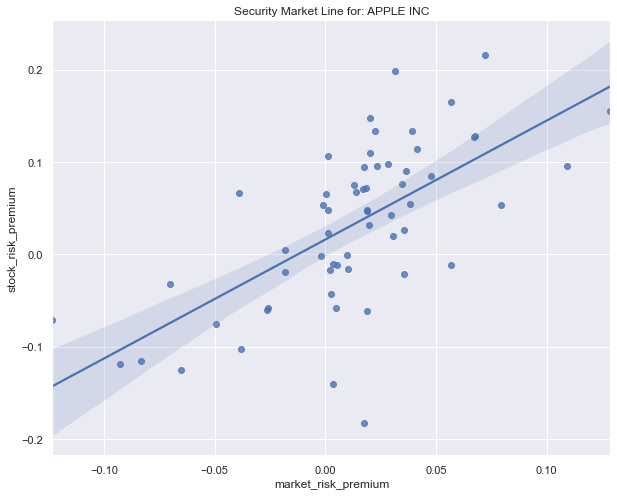

In [15]:
company_name = cleaned_data['name'].iloc[0]

sns.set(rc={'figure.figsize':(10,8)})
sns.regplot(data=cleaned_data, y='stock_risk_premium', x='market_risk_premium')
plt.title(f'Security Market Line for: {company_name}')
plt.show()

#### Fit Regression:

In [16]:
model = ols('stock_risk_premium ~ market_risk_premium', data = cleaned_data)
results = model.fit()

### Summary Statistics

In [17]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     stock_risk_premium   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     43.18
Date:                Tue, 26 Oct 2021   Prob (F-statistic):           1.53e-08
Time:                        11:04:51   Log-Likelihood:                 78.503
No. Observations:                  60   AIC:                            -153.0
Df Residuals:                      58   BIC:                            -148.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0159    

### ANOVA Table

In [18]:
anova_table = sm.stats.anova_lm(results, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
market_risk_premium,0.19102,1.00000,43.17880,0.00000
Residual,0.25658,58.00000,NaN,NaN


### Hypothesis Test of Alpha

In [19]:
intercept_p = round(results.pvalues[0], 5)
if (intercept_p < 0.05):
    print(f'Alpha with a P value of {intercept_p} is statistically significant.')
else:
    print(f'Alpha with a P value of {intercept_p} is not statistically significant.')

Alpha with a P value of 0.07892 is not statistically significant.


### Hypothesis Test of Beta

In [20]:
mrp_p = round(results.pvalues[1], 5)
if (mrp_p < 0.05):
    print(f'Beta with a P value of {mrp_p} is statistically significant.')
else:
    print(f'Beta with a P value of {mrp_p} is not statistically significant.')

Beta with a P value of 0.0 is statistically significant.


### Regression Assumptions:
* Linearity: Tested by examining the plot of market risk premium against stock risk premium for any evidence of a non-linear relationship.
* Independence of residuals: Tested by examining the Durbin-Watson statistic in regression summary output above.
* Homoskedasticity: Tested by examining the plot of market risk premium against residuals below.
* Normality: Tested by examining Jarque-Bera Statistic in regression summary output and normal probability plot below.

#### Residual Plot:

Text(0.5, 1.0, 'Residual vs Independent Variable')

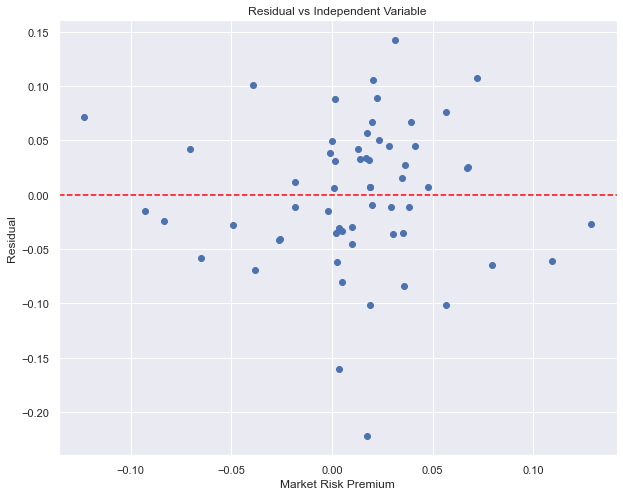

In [21]:
plt.scatter(cleaned_data['market_risk_premium'],results.resid)
plt.axhline(y=0, linestyle='--', color='red')
plt.xlabel('Market Risk Premium')
plt.ylabel('Residual')
plt.title('Residual vs Independent Variable')

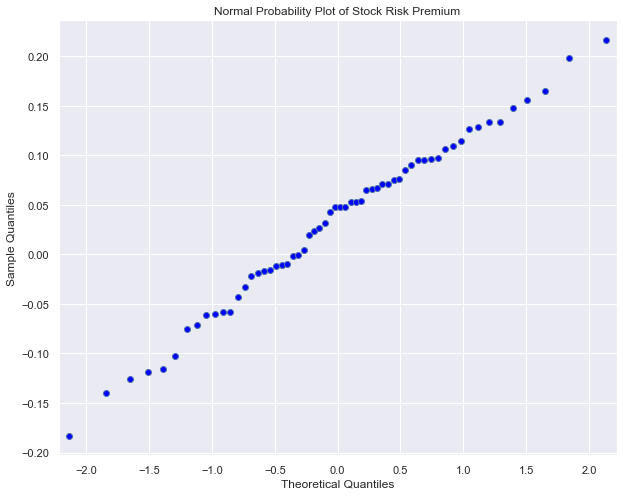

In [22]:
sm.qqplot(cleaned_data['stock_risk_premium'].values);
plt.title('Normal Probability Plot of Stock Risk Premium');